Alternative Model: concantenation of VGG Places  activations with ResNet50

References:

https://github.com/GKalliatakis/Keras-VGG16-places365
http://places2.csail.mit.edu/download.html
https://www.kaggle.com/rsmits/keras-landmark-or-non-landmark-identification

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
import os
import gc
import seaborn as sns
import tensorflow as tf
import scipy.misc

from os import listdir
from os.path import isfile, join

from skimage.transform import resize

import warnings
print('TF',tf.__version__)
print('NP',np.__version__)

TF 1.13.1
NP 1.16.4


In [3]:
def download_labels():
  
  if  os.path.isfile('train.csv')==False:

    !wget 'https://s3.amazonaws.com/google-landmark/metadata/train.csv'

  train_data = pd.read_csv('train.csv')
  print('Number of examples: ',len(train_data))
  
  return train_data
  
train_data=download_labels()

Number of examples:  4132914


In [4]:
print("Training data size",train_data.shape)
#print("test data size",test_data.shape)
#submission.head()
#Training data size (1 225 029, 3)

Training data size (4132914, 3)


In [5]:
import requests
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import threading
import urllib
import cv2
import time

import keras
from keras.applications import ResNet50,InceptionResNetV2
from keras.applications import DenseNet121
from keras import backend as K
from keras import regularizers
from keras.engine.topology import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, \
    Lambda, MaxPooling2D, Reshape, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.utils import Sequence
from sklearn.model_selection import train_test_split

from collections import Counter

import os

Using TensorFlow backend.


In [0]:

NUM_THRESHOLD = 250
train=train_data

counts = dict(Counter(train['landmark_id']))
landmarks_dict = {x:[] for x in train.landmark_id.unique() if counts[x] >= NUM_THRESHOLD}
NUM_CLASSES = len(landmarks_dict)
print("Total number of valid classes: {}".format(NUM_CLASSES))

i = 0
landmark_to_idx = {}
idx_to_landmark = []
for k in landmarks_dict:
    landmark_to_idx[k] = i
    idx_to_landmark.append(k)
    i += 1

all_urls = train['url'].tolist()
all_landmarks = train['landmark_id'].tolist()
valid_urls_dict = {x[0].split("/")[-1]:landmark_to_idx[x[1]] for x in zip(all_urls, all_landmarks) if x[1] in landmarks_dict}
valid_urls_list = [x[0] for x in zip(all_urls, all_landmarks) if x[1] in landmarks_dict]

NUM_EXAMPLES = len(valid_urls_list)
print("Total number of valid examples: {}".format(NUM_EXAMPLES))

Total number of valid classes: 1067
Total number of valid examples: 478577


In [0]:
train1_urls, test_urls = train_test_split(valid_urls_list, test_size=1.2*NUM_CLASSES/NUM_EXAMPLES,random_state=1234)
train_urls, validation_urls = train_test_split(train1_urls, test_size=1.2*NUM_CLASSES/NUM_EXAMPLES,random_state=1234)

In [0]:
def download_image_cv2_urllib(url):
    """
    Modifying the url to download the 360p or 720p version actually slows it down. 
    """
    try:
        resp = urllib.request.urlopen(url)
        foo = np.asarray(bytearray(resp.read()), dtype="uint8")
        img_original = cv2.imdecode(foo, cv2.IMREAD_COLOR)
        foo = cv2.resize(img_original,(224, 224), interpolation=cv2.INTER_AREA)
        return foo,img_original
    except:
        return np.array([]),np.array([])

In [0]:
## downloading validation set

def download_urls(urls):

  images = []
  y_label = []
  
  i=0
  for url in urls:
    im,_ = download_image_cv2_urllib(url)
    if im.size != 0:
        i=+i
        images.append(im)
        y_label.append(valid_urls_dict[url.split("/")[-1]])
    if i%500==0 and i>500:
      print('Downloaded: '+str(i))
    
  x = np.array(images)
  y = np.zeros((len(images), NUM_CLASSES))
        
  for i in range(len(y_label)):
    y[i,y_label[i]] = 1.
    
  return x,y

In [0]:
valid_x,valid_y=download_urls(validation_urls)
test_x,test_y=download_urls(test_urls)

In [0]:
def randomCrop(img, width, height):

    
    x = random.randint(0, max(img.shape[1] - width,0))
    y = random.randint(0, max(img.shape[0] - height,0))
    
    img_crop = img[y:y+height, x:x+width]
    return img_crop



class DataGen(Sequence):
    def __init__(self, data, batch_size=24, verbose=1):
        self.batch_size=batch_size
        self.data_urls = data

    def normalize(self,data):
        return data
    
    def __getitem__(self, index):
      
        number_of_crops=1
        
        batch_urls = random.sample(self.data_urls, int(self.batch_size/number_of_crops))

        
        output = []
        y_classes = []
        
        for url in batch_urls:
            im,original = download_image_cv2_urllib(url)
            if im.size != 0:
              
                output.append(im)
                y_classes.append(valid_urls_dict[url.split("/")[-1]])
                if original.shape[0]<=224 or original.shape[1]<=224: 
                  original=cv2.resize(original,(256, 256), interpolation=cv2.INTER_AREA)
                for k in range(number_of_crops-1):
                  
                  im=randomCrop(original,128,128)
                  output.append(im)
                  y_classes.append(valid_urls_dict[url.split("/")[-1]])
                  
        
        x = np.array(output)
        y = np.zeros((len(output), NUM_CLASSES))
        
        for i in range(len(y_classes)):
            y[i,y_classes[i]] = 1.
       
        
        return [x,x],y
            
    def on_epoch_end(self):
        return

    def __len__(self):
        #return len(valid_urls_list) // self.batch_size
        return 40
      
def accuracy_class(y_true, y_pred):
    true = K.argmax(y_true, axis=1)
    pred = K.argmax(y_pred, axis=1)
    matches = K.equal(true, pred)
    return K.mean(matches)
  
def batch_GAP(y_t, y_p):
  
    import tensorflow as tf
    pred_cat = tf.argmax(y_p, axis=-1)    
    y_t_cat = tf.argmax(y_t, axis=-1) * tf.cast(
        tf.reduce_sum(y_t, axis=-1), tf.int64)
    
    n_pred = tf.shape(pred_cat)[0]
    is_c = tf.cast(tf.equal(pred_cat, y_t_cat), tf.float32)

    GAP = tf.reduce_mean(
          tf.cumsum(is_c) * is_c / tf.cast(
              tf.range(1, n_pred + 1), 
              dtype=tf.float32))
    
    return GAP  
  
def binary_crossentropy_n_cat(y_t, y_p):
    return keras.metrics.binary_crossentropy(y_t, y_p) * NUM_CLASSES

#GeM

gm_exp = tf.Variable(3., dtype=tf.float32)
def generalized_mean_pool_2d(X):
    import tensorflow as tf
    #gm_exp = tf.Variable(3., dtype=tf.float32)
    
    pool = (tf.reduce_mean(tf.abs(X**(gm_exp)), 
                           axis=[1,2], 
                           keepdims=False)+1.e-8)**(1./gm_exp)
    return pool

In [0]:
# VGG 16 Places 365 scripts in custom dataset
os.chdir("/content/drive/My Drive/CS231n/Project/VGG_places/")
from vgg16_places_365 import VGG16_Places365
os.chdir("/content/drive/My Drive/CS231n/Project/VGG_places/working/")
# Places365 Model
vgg = VGG16_Places365(weights='places',include_top=True)#, input_shape=(128, 128, 3))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
for layer in vgg.layers[:22]:
    layer.trainable = False


In [0]:
 vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:

#res_net 128?
res_net=ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
print(len(res_net.layers))
for layer in res_net.layers[:120]:
    layer.trainable = False

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


175


In [0]:
res_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate,MaxPooling1D,AveragePooling2D

X_image_r=Input(res_net.input_shape[1:])
X_image_v=Input(vgg.input_shape[1:])

#4096
v=vgg.layers[-5].output

VGG_model=Model(inputs=vgg.input,outputs=v)

x_f_vgg=VGG_model(X_image_v)
x_f_vgg=MaxPooling1D(pool_size=(2))(x_f_vgg)


x_f_res_net=res_net(X_image_r)
x_f_res_net=MaxPooling2D(pool_size=(2,2))(x_f_res_net)
x_f_res_net=AveragePooling2D(pool_size=(3,3))(x_f_res_net)
x_f_res_net=Flatten()(x_f_res_net)
x_f_res_net=Dense(4096)(x_f_res_net)

merge_one = concatenate([x_f_vgg, x_f_res_net], axis=1)
#merge_one=Flatten()(merge_one)
#addd pooling

merge_one = Dense(1024, activation="relu")(merge_one)
merge_one = Dropout(0.05)(merge_one)
merge_one = Dense(512, activation="relu")(merge_one)
merge_one = Dense(NUM_CLASSES, activation='softmax')(merge_one)

model_concat = Model(inputs=[X_image_r, X_image_v], outputs=merge_one)

#X_feat=Input(model_concat.output_shape[1:])


#model_final=top_model(model_concat)

In [0]:
model_concat.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
resnet50 (Model)                (None, 7, 7, 2048)   23587712    input_13[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 3, 3, 2048)   0           resnet50[6][0]                   
__________________________________________________________________________________________________
average_pooling2d_3 (AveragePoo (None, 1, 1, 2048)   0           max_pooling2d_6[0][0]            
__________________________________________________________________________________________________
input_14 (

In [0]:
from keras.callbacks import History, CSVLogger,ReduceLROnPlateau,ModelCheckpoint
history = keras.callbacks.History()

model=model_concat

model_name='concat_model_0603'

LOG_DIR='/content/drive/My Drive/CS231n/Project/LOG/'
Check_DIR='/content/drive/My Drive/CS231n/Project/Checkpoints/'


csv_logger = CSVLogger(LOG_DIR+'training_'+model_name+'.log')



opt = Adam(0.0001)
#opt = Adam(0.00001)

checkpoint_name=model_name+'.h5'
checkpoint_filepath=Check_DIR+checkpoint_name



checkpoint=keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=[accuracy_class,batch_GAP,binary_crossentropy_n_cat])

#check dir
if os. path. isfile(checkpoint_filepath):

  model.load_weights(checkpoint_filepath)

  print("Best weights loaded")
  
model.fit_generator(generator=DataGen(train_urls, batch_size=64),
                    shuffle=True,
             
                    #validation_data=[[valid_x,valid_x], valid_y],
                    epochs=10,
                    use_multiprocessing=True,
                    workers=8,
                    verbose=1,
                    callbacks=[history,reduce_lr,csv_logger,checkpoint
                              ])



Epoch 1/40
40/40 [==============================] - 370s 9s/step - loss: 0.2422 - accuracy_class: 0.0633 - batch_GAP: 0.0083 - binary_crossentropy_n_cat: 7.5142


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy_class,batch_GAP,binary_crossentropy_n_cat,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/40
40/40 [==============================] - 353s 9s/step - loss: 0.2420 - accuracy_class: 0.0852 - batch_GAP: 0.0114 - binary_crossentropy_n_cat: 7.2771
Epoch 3/40
40/40 [==============================] - 362s 9s/step - loss: 0.2418 - accuracy_class: 0.1055 - batch_GAP: 0.0199 - binary_crossentropy_n_cat: 7.0558
Epoch 4/40
40/40 [==============================] - 363s 9s/step - loss: 0.2416 - accuracy_class: 0.1160 - batch_GAP: 0.0203 - binary_crossentropy_n_cat: 6.8681
Epoch 5/40
40/40 [==============================] - 369s 9s/step - loss: 0.2414 - accuracy_class: 0.1110 - batch_GAP: 0.0202 - binary_crossentropy_n_cat: 6.7024
Epoch 6/40
40/40 [==============================] - 362s 9s/step - loss: 0.2413 - accuracy_class: 0.1302 - batch_GAP: 0.0229 - binary_crossentropy_n_cat: 6.5752
Epoch 7/40
40/40 [==============================] - 359s 9s/step - loss: 0.2411 - accuracy_class: 0.1473 - batch_GAP: 0.0351 - binary_crossentropy_n_cat: 6.3381
Epoch 8/40
40/40 [================

KeyboardInterrupt: ignored

In [0]:

x_=valid_x
y_=valid_y

def val_gap(x_,y_):

  result=model.predict(x_, batch_size=128, verbose=0, steps=None)

  true_=y_.astype('int64')
  pred_=result

  _,acc=tf.metrics.average_precision_at_k(true_,pred_,1)
  custom_gap=batch_GAP(true_,pred_)

  sess = tf.Session()
  sess.run(tf.local_variables_initializer())

  print('Validation GAP: ',sess.run(acc))
  print('Custom GAP: ', sess.run(custom_gap))

val_gap(x_,y_)



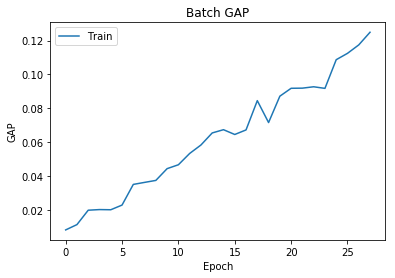

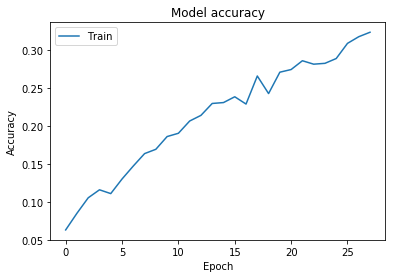

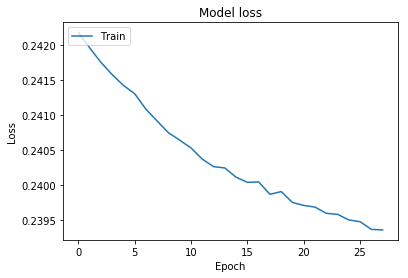

In [0]:
import matplotlib.pyplot as plt

include_list=['Train']

#history
#loss: 0.0086 - accuracy_class
# Plot training & validation accuracy values
plt.plot(history.history['batch_GAP'])
#plt.plot(history.history['val_batch_GAP'])
plt.title('Batch GAP')
plt.ylabel('GAP')
plt.xlabel('Epoch')
plt.legend(include_list, loc='upper left')
plt.show()

plt.plot(history.history['accuracy_class'])
#plt.plot(history.history['val_accuracy_class'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(include_list, loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(include_list, loc='upper left')
plt.show()